In [83]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Carrega Dados
url = 'https://raw.githubusercontent.com/Borgarelli/IAHourly_energy_demand_generation_weather/main/seattle-weather.csv'
data = pd.read_csv(url)
data.head(500)

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
495,2013-05-10,0.0,26.1,9.4,1.0,sun
496,2013-05-11,0.0,27.2,12.2,2.6,sun
497,2013-05-12,6.6,21.7,13.9,3.9,rain
498,2013-05-13,3.3,18.9,9.4,5.0,rain


In [84]:
clouds = data[['date', 'temp_max']]
clouds = clouds.dropna()
clouds.head()

,date,temp_max
0,2012-01-01,12.8
1,2012-01-02,10.6
2,2012-01-03,11.7
3,2012-01-04,12.2
4,2012-01-05,8.9


In [85]:
# Converter a coluna 'date' em um índice de data e hora
clouds['date'] = pd.to_datetime(clouds['date'])

# Definir 'date' como o índice
clouds = clouds.set_index('date')

# Resample para frequência mensal ('M') e calcular a média dos valores dentro de cada mês
clouds = clouds.asfreq('MS', fill_value=0.0)

# Exibe o DataFrame resultante
clouds.head()


,temp_max
date,
2012-01-01,12.8
2012-02-01,8.9
2012-03-01,6.1
2012-04-01,8.9
2012-05-01,11.7


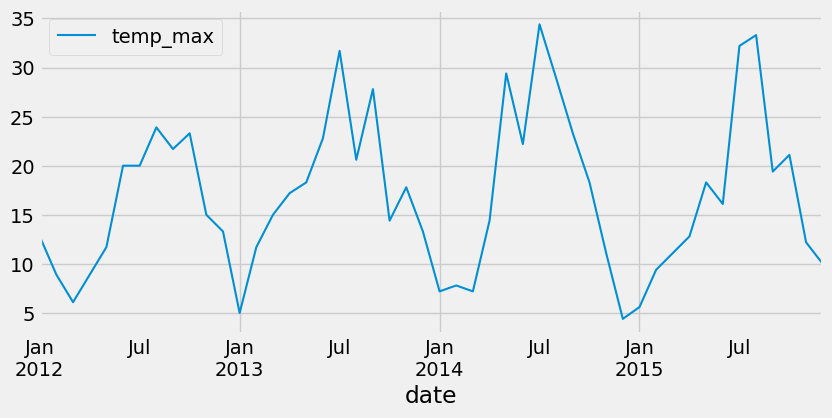

In [86]:
# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Plota os dados
fig, ax = plt.subplots(figsize=(9, 4))
clouds['temp_max'].plot(ax=ax, label='temp_max')
ax.legend();

Train dates : 2012-01-01 00:00:00 --- 2014-12-01 00:00:00  (n=36)
Test dates  : 2015-01-01 00:00:00 --- 2015-12-01 00:00:00  (n=12)


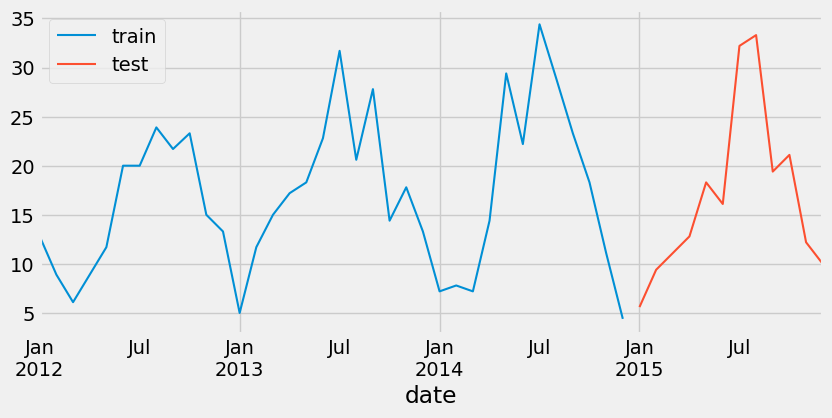

In [87]:
# Divide dados em treinamento e teste
# Para séries temporais, sempre utilizamos os dados mais recentes para teste
steps = 12
data_train = clouds[:-steps]
data_test  = clouds[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['temp_max'].plot(ax=ax, label='train')
data_test['temp_max'].plot(ax=ax, label='test')
ax.legend();

In [88]:
pip install pmdarima

In [89]:
# O ARIMA vem com um tunning automático, o auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(data_train['temp_max'], seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
# Treina o modelo
model.fit(data_train['temp_max'])
# Previsao
forecast = model.predict(n_periods=len(data_test))
# Converte para um dataframe
forecast = pd.DataFrame(forecast,index = data_test.index,columns=['Prediction'])
forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=215.621, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=253.602, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=237.493, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=244.858, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=314.739, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=230.767, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=240.326, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=239.491, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=232.324, Time=0.29 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=216.114, Time=0.85 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=220.448, Time=1.45 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=239.084, Time=0.32 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fi

,Prediction
date,
2015-01-01,6.127490
2015-02-01,7.852551
2015-03-01,12.321167
2015-04-01,18.209492
2015-05-01,23.781046
2015-06-01,27.398784
2015-07-01,28.006075
2015-08-01,25.435276
2015-09-01,20.453797


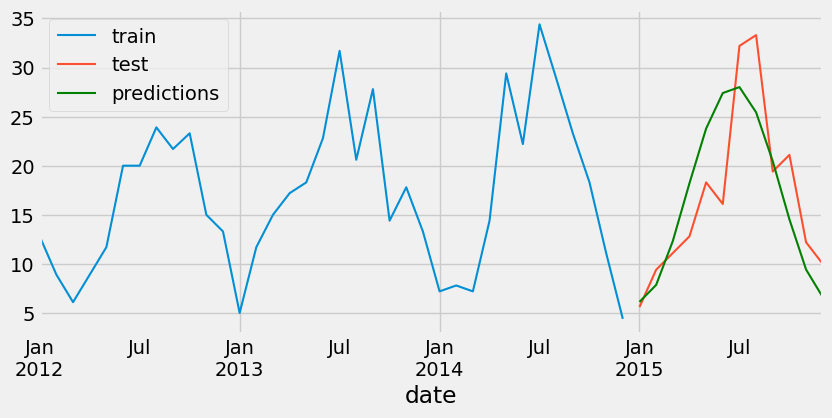

In [93]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(9, 4))
data_train['temp_max'].plot(ax=ax, label='train')
data_test['temp_max'].plot(ax=ax, label='test')
forecast['Prediction'].plot(ax=ax, label='predictions', color='green')
ax.legend();